In [202]:
using Pkg
using Statistics
using StatsModels
using GLM
using CSV
using DataFrames
using Distributions
#using Plots
using Gadfly


## Modules

### Find Propensity Scores

In [203]:
Pkg.add("StatsBase")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [

Fetching: [========================================>]  99.9 %                      ]  44.6 % [======================>                  ]  52.7 %72.9 %73.1 %======================================>  ]  93.5 %

  Resolving package versions...
Updating `~/Desktop/propensity_scoring/propensity.jl/Propensity/Project.toml`
  [2913bbd2] + StatsBase v0.33.2
No Changes to `~/Desktop/propensity_scoring/propensity.jl/Propensity/Manifest.toml`


In [204]:
using StatsBase:sample

In [208]:
size(df)[1]

400

In [243]:

# split to minority and majority class
# record size of minority class (n)
function split_by_class(df, target)
    target = Symbol(target)
    df_1 = df[df[target] .== 1, :]
    df_2 = df[df[target] .== 0, :]
    min_cls_size = size(df_1)[1]
    return df_1, df_2, min_cls_size
end

  
# Generate n samples of majority class of random subsample size n
function sample_majority(df_0, df_1, n)
    samples_list = []
    
    for i in 1:n
        df_0_sampled = sample(1:nrow(df_0), n, replace=true)
        df_train = [df_0_sampled; df_1]
        append!(samples_list, df_train)
    end
    return samples_list
end
    

sample_majority (generic function with 2 methods)

In [244]:
df2 = select(df_train, Not([:death, :male]));

In [245]:
df_1, df_2, min_cls_size = split_by_class(df2, "trt")

(141×4 DataFrame
│ Row │ age   │ risk  │ severity │ trt   │
│     │ Int64 │ Int64 │ Int64    │ Int64 │
├─────┼───────┼───────┼──────────┼───────┤
│ 1   │ 59    │ 4     │ 6        │ 1     │
│ 2   │ 56    │ 1     │ 6        │ 1     │
│ 3   │ 53    │ 0     │ 3        │ 1     │
│ 4   │ 64    │ 2     │ 6        │ 1     │
│ 5   │ 70    │ 3     │ 8        │ 1     │
│ 6   │ 51    │ 1     │ 5        │ 1     │
│ 7   │ 59    │ 0     │ 3        │ 1     │
│ 8   │ 69    │ 3     │ 3        │ 1     │
│ 9   │ 57    │ 1     │ 5        │ 1     │
│ 10  │ 61    │ 2     │ 9        │ 1     │
⋮
│ 131 │ 52    │ 0     │ 4        │ 1     │
│ 132 │ 60    │ 2     │ 4        │ 1     │
│ 133 │ 55    │ 4     │ 6        │ 1     │
│ 134 │ 58    │ 1     │ 7        │ 1     │
│ 135 │ 52    │ 2     │ 6        │ 1     │
│ 136 │ 70    │ 2     │ 5        │ 1     │
│ 137 │ 43    │ 0     │ 2        │ 1     │
│ 138 │ 70    │ 5     │ 6        │ 1     │
│ 139 │ 69    │ 5     │ 5        │ 1     │
│ 140 │ 63    │ 1     │ 6        │ 

In [242]:

# split to minority and majority class
# record size of minority class (n)
function split_by_class(df, target)
    target = Symbol(target)
    df_1 = df[:, [target] .== 1]
    df_2 = df[:, [target] .== 0]
    min_cls_size = size(df_1)[1]
    return df_1, df_2, min_cls_size
end

  
# Generate n samples of majority class of random subsample size n
function sample_majority(df_0, df_1, n)
    samples_list = []
    
    for i in 1:n
        df_0_sampled = sample(1:nrow(df_0), n, replace=true)
        df_train = [df_0_sampled; df_1]
        append!(samples_list, df_train)
    end
    return samples_list
end
    
    
# concat minority and n subsampled majorities
# train n logit

# df = DataFrame(a = 1:1000)


sample_rows = sample(1:nrow(df), 100, replace=false)

df_sample = df[sample_rows, :]

test_rows = setdiff(1:nrow(df), sample_rows)

df_test = df[test_rows, :];

In [147]:
function assign_formula(y, df)
    
    y = Symbol(y)
    fm = term(y) ~ sum(term.(Symbol.(names(df, Not(y)))))
    return fm
end
  

function fit_logit(y, df)
    
    fm = assign_formula(y, df)
    
    logit = glm(fm, df, Binomial(), LogitLink())
    return logit
end

    
function assign_propensity_scores(df, logit)
    
    df[!,Symbol("Propensity_Scores")] = predict(logit, df)
    return df
end



assign_propensity_scores (generic function with 1 method)

### Module: Stratification/Matching

In [68]:
function assign_quartile(x, Q1, Q2, Q3, Q4)
    if x .<= Q1
        return "Q1"
    elseif x .<= Q2
        return "Q2"
    elseif x .<= Q3
        return "Q3"
    else
        return "Q4"
    end
end


function quartile_col(df, col, new_col)
    
    Q1, Q2, Q3, Q4 = quantile(df[!, Symbol(col)], [0.25 0.5 0.75 1.0])
    
    df = sort(df, [order(Symbol(col), rev=false)])
    
    df[!, Symbol(new_col)] = assign_quartile.(df[:, Symbol(col)], Q1, Q2, Q3, Q4)
    
    return df
end


function sample_by_covariate_quartile()   
end


function sample_by_propensity_score()   
end



sample_by_propensity_score (generic function with 1 method)

### Module Visualize

In [190]:
function plot_prop_by_factor(df, factor)
    set_default_plot_size(12cm, 8cm)
    
    fig = plot(
        df,
        x=Symbol(factor),
        y=:Propensity_Scores, 
        color=Symbol(factor),
        Stat.x_jitter(range=0.5),
        Guide.title("Propensity Score")
    ) 
    return fig
end
    


function plot_prop_by_covariate(
        df,
        factor,
        covariate,
        covariate_quartiles
    )
    
    set_default_plot_size(21cm, 8cm)
    
    factor = Symbol(factor)
    covariate = Symbol(covariate)
    covariate_quartiles = Symbol(covariate_quartiles)

    covariate_by_prop = plot(
    df,
        x=covariate,
        y=:Propensity_Scores, 
    color=factor,
        Stat.x_jitter(range=0.5),
    Guide.title("$covariate by Propensity Score")
    )
    covariate_quartile_by_prop = plot(
    df,
        x=covariate_quartiles,
        y=:Propensity_Scores, 
    color=factor,
        Stat.x_jitter(range=0.5),
    Guide.title("$covariate Quartile by Propensity Score")
    )

    h = hstack(covariate_by_prop, covariate_quartile_by_prop)
    
    return h
end
    
    

plot_prop_by_covariate (generic function with 1 method)

### Module: Misc

In [53]:
function scale(X)
    X_mean= mean(X, dims=1)
    X_std = std(X, dims=1)

    X_norm = (X .- X_mean) ./ X_std
    
    return X_norm, X_mean, X_std
end


function scale_transform(X, X_mean, X_std)
    
    X_norm = (X .- X_mean) ./ X_std
    return X_norm
end


function sigmoid(z)
    return 1 ./ (1 .+ exp.(.-z))
end


sigmoid (generic function with 1 method)

### Demo Data

* <b>Subjects</b>: 400 subjects (male) from retrospective cohort study hospital with suspected MI.
* <b>Outcome</b>: 30-day mortality (death=1)
* <b>Intervention</b>: Rapid administration of a new clot-busting drug (trt=1) versus a standard therapy (trt=0)
* <b>Source</b>: http://web.hku.hk/~bcowling/data/propensity.csv

In [205]:
df = CSV.File("../../data/propensity.csv") |> DataFrame;
head(df)

6×6 DataFrame
│ Row │ age   │ male  │ risk  │ severity │ trt   │ death │
│     │ Int64 │ Int64 │ Int64 │ Int64    │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┼──────────┼───────┼───────┤
│ 1   │ 48    │ 1     │ 3     │ 8        │ 0     │ 0     │
│ 2   │ 59    │ 1     │ 4     │ 6        │ 1     │ 0     │
│ 3   │ 67    │ 1     │ 3     │ 6        │ 0     │ 1     │
│ 4   │ 51    │ 1     │ 0     │ 6        │ 0     │ 0     │
│ 5   │ 56    │ 1     │ 1     │ 6        │ 1     │ 0     │
│ 6   │ 60    │ 1     │ 1     │ 6        │ 0     │ 0     │

In [103]:
size(df)

(400, 6)

In [177]:
df_train = df[begin:300,:]
df_test = df[300:end,:];

In [178]:
println(names(df))

["age", "male", "risk", "severity", "trt", "death"]


### Calculate Propensity Score of Treatment

In [195]:
names(df_test)

6-element Array{String,1}:
 "age"
 "male"
 "risk"
 "severity"
 "trt"
 "death"

In [196]:
df2 = select(df_train, Not([:death, :male]));

# fit logit function
fm = assign_formula("trt", df2);
logit = fit_logit(fm, df2)

# Assign propensity scores

df2 = assign_propensity_scores(df,logit) 

head(df2)

6×7 DataFrame
│ Row │ age   │ male  │ risk  │ severity │ trt   │ death │ Propensity_Scores │
│     │ Int64 │ Int64 │ Int64 │ Int64    │ Int64 │ Int64 │ Float64?          │
├─────┼───────┼───────┼───────┼──────────┼───────┼───────┼───────────────────┤
│ 1   │ 48    │ 1     │ 3     │ 8        │ 0     │ 0     │ 0.537539          │
│ 2   │ 59    │ 1     │ 4     │ 6        │ 1     │ 0     │ 0.627556          │
│ 3   │ 67    │ 1     │ 3     │ 6        │ 0     │ 1     │ 0.661203          │
│ 4   │ 51    │ 1     │ 0     │ 6        │ 0     │ 0     │ 0.376162          │
│ 5   │ 56    │ 1     │ 1     │ 6        │ 1     │ 0     │ 0.468088          │
│ 6   │ 60    │ 1     │ 1     │ 6        │ 0     │ 0     │ 0.508426          │

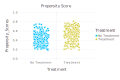

In [197]:
# Label patients by treatment (yes/no)
df2[!, Symbol("Treatment")] .= ifelse.(
  df2.trt .== 1, "Treatment", "No Treatment");

plot_prop_by_factor(df2, "Treatment")

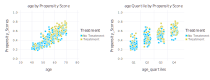

In [194]:
df2 = quartile_col(df2, "age", "age_quartiles");

plot_prop_by_covariate(
        df2,
        "Treatment",
        "age",
        "age_quartiles"
    )

In [154]:
#### Initial setup

In [9]:
# Propensity for intervetion given covariates
fm = @formula(trt ~ age + risk + severity)

FormulaTerm
Response:
  trt(unknown)
Predictors:
  age(unknown)
  risk(unknown)
  severity(unknown)

In [10]:
logit = glm(fm, df_train, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

trt ~ 1 + age + risk + severity

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.31244     0.986663   -3.36    0.0008  -5.24626     -1.37862
age           0.0403817   0.0182184   2.22    0.0267   0.00467423   0.0760892
risk          0.176141    0.105609    1.67    0.0953  -0.0308482    0.383131
severity      0.124517    0.0615208   2.02    0.0430   0.00393811   0.245095
─────────────────────────────────────────────────────────────────────────────

In [16]:
# Assign propensity scores
df_train[!,Symbol("Propensity_Scores")] = predict(logit, df_train);

# Label patients by treatment (yes/no)
df_train[!, Symbol("Treatment")] .= ifelse.(
  df_train.trt .== 1, "Treatment", "No Treatment");

# Mean propensity score by treatment group
by(df_train, :Treatment, :Propensity_Scores => mean)

2×2 DataFrame
│ Row │ Treatment    │ Propensity_Scores_mean │
│     │ String       │ Float64                │
├─────┼──────────────┼────────────────────────┤
│ 1   │ No Treatment │ 0.426885               │
│ 2   │ Treatment    │ 0.518619               │

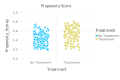

In [19]:
# Visualize propensity score by treatment
set_default_plot_size(12cm, 8cm)

plot(
df_train,
    x=:Treatment,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Propensity Score")
)

In [46]:
# Inspect age as a confounder
df_train = quartile_col(df_train, "age", "age_quartile");

# Mean propensity score by treatment group
by(df_train, [:age_quartile, :Treatment], :Propensity_Scores => mean)

8×3 DataFrame
│ Row │ age_quartile │ Treatment    │ Propensity_Scores_mean │
│     │ String       │ String       │ Float64                │
├─────┼──────────────┼──────────────┼────────────────────────┤
│ 1   │ Q1           │ No Treatment │ 0.288199               │
│ 2   │ Q1           │ Treatment    │ 0.321004               │
│ 3   │ Q2           │ No Treatment │ 0.445793               │
│ 4   │ Q2           │ Treatment    │ 0.445167               │
│ 5   │ Q3           │ Treatment    │ 0.539874               │
│ 6   │ Q3           │ No Treatment │ 0.497288               │
│ 7   │ Q4           │ Treatment    │ 0.660765               │
│ 8   │ Q4           │ No Treatment │ 0.582769               │

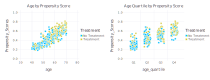

In [25]:
set_default_plot_size(21cm, 8cm)

age_by_prop = plot(
df_train,
    x=:age,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Age by Propensity Score")
);

age_by_prop_quart = plot(
df_train,
    x=:age_quartile,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Age Quartile by Propensity Score")
);

hstack(age_by_prop, age_by_prop_quart)

#### Generate propensity scores on new data

In [ ]:
prediction = predict(logit, df_test);

In [ ]:
df_test[!,Symbol("Propensity_Scores")] = prediction;

df_test[!, Symbol("Treatment")] .= ifelse.(
  df_test.trt .== 1, "Treatment", "No Treatment");

plot(
df_test,
    x=:Treatment,
    y=:Propensity_Scores, 
color=:Treatment,
    Stat.x_jitter(range=0.5),
Guide.title("Propensity Score")
)